<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Model-Zoo----Convolutional-Neural-Network-(VGG16)" data-toc-modified-id="Model-Zoo----Convolutional-Neural-Network-(VGG16)-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Model Zoo -- Convolutional Neural Network (VGG16)</a></span><ul class="toc-item"><li><span><a href="#Imports" data-toc-modified-id="Imports-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Imports</a></span></li><li><span><a href="#Settings-and-Dataset" data-toc-modified-id="Settings-and-Dataset-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Settings and Dataset</a></span></li><li><span><a href="#Model" data-toc-modified-id="Model-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Model</a></span></li><li><span><a href="#Training" data-toc-modified-id="Training-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Training</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></li></ul></div>

Deep Learning Models -- A collection of various deep learning architectures, models, and tips for TensorFlow and PyTorch in Jupyter Notebooks.
- Author: Sebastian Raschka
- GitHub Repository: https://github.com/rasbt/deeplearning-models

In [1]:
!pip install -q IPython
!pip install -q ipykernel
!pip install -q watermark
!pip install -q matplotlib
!pip install -q sklearn
!pip install -q pandas
!pip install -q pydot
!pip install -q hiddenlayer
!pip install -q graphviz

In [2]:
%load_ext watermark
%watermark -a 'Sebastian Raschka' -v -p torch

Sebastian Raschka 

CPython 3.6.9
IPython 5.5.0

torch 1.5.1+cu101


- Runs on CPU (not recommended here) or GPU (if available)

# Model Zoo -- Convolutional Neural Network (VGG16)

## Imports

In [3]:
import time
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader


if torch.cuda.is_available():
    torch.backends.cudnn.deterministic = True

## Settings and Dataset

In [4]:
##########################
### SETTINGS
##########################

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)

# Hyperparameters
random_seed = 1
learning_rate = 0.001
num_epochs = 10
batch_size = 128

# Architecture
num_features = 784
num_classes = 10


##########################
### MNIST DATASET
##########################

# Note transforms.ToTensor() scales input images
# to 0-1 range
train_dataset = datasets.CIFAR10(root='data', 
                                 train=True, 
                                 transform=transforms.ToTensor(),
                                 download=True)

test_dataset = datasets.CIFAR10(root='data', 
                                train=False, 
                                transform=transforms.ToTensor())


train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=batch_size, 
                          shuffle=True)

test_loader = DataLoader(dataset=test_dataset, 
                         batch_size=batch_size, 
                         shuffle=False)

# Checking the dataset
for images, labels in train_loader:  
    print('Image batch dimensions:', images.shape)
    print('Image label dimensions:', labels.shape)
    break

Device: cuda


Extracting data/cifar-10-python.tar.gz to data
Image batch dimensions: torch.Size([128, 3, 32, 32])
Image label dimensions: torch.Size([128])


## Model

In [5]:
##########################
### MODEL
##########################


class VGG16(torch.nn.Module):

    def __init__(self, num_features, num_classes):
        super(VGG16, self).__init__()
        
        # calculate same padding:
        # (w - k + 2*p)/s + 1 = o
        # => p = (s(o-1) - w + k)/2
        
        self.block_1 = nn.Sequential(
                nn.Conv2d(in_channels=3,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          # (1(32-1)- 32 + 3)/2 = 1
                          padding=1), 
                nn.ReLU(),
                nn.Conv2d(in_channels=64,
                          out_channels=64,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_2 = nn.Sequential(
                nn.Conv2d(in_channels=64,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=128,
                          out_channels=128,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_3 = nn.Sequential(        
                nn.Conv2d(in_channels=128,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=256,
                          out_channels=256,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
          
        self.block_4 = nn.Sequential(   
                nn.Conv2d(in_channels=256,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),        
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))
        )
        
        self.block_5 = nn.Sequential(
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),            
                nn.Conv2d(in_channels=512,
                          out_channels=512,
                          kernel_size=(3, 3),
                          stride=(1, 1),
                          padding=1),
                nn.ReLU(),    
                nn.MaxPool2d(kernel_size=(2, 2),
                             stride=(2, 2))             
        )
            
        self.classifier = nn.Sequential(
            nn.Linear(512, 4096),
            nn.ReLU(True),
            #nn.Dropout(p=0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            #nn.Dropout(p=0.5),
            nn.Linear(4096, num_classes),
        )
            
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d) or isinstance(m, torch.nn.Linear):
                nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    m.bias.detach().zero_()
                    
        #self.avgpool = nn.AdaptiveAvgPool2d((7, 7))
        
        
    def forward(self, x):

        x = self.block_1(x)
        x = self.block_2(x)
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        #x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.classifier(x)
        probas = F.softmax(logits, dim=1)

        return logits, probas

    
torch.manual_seed(random_seed)
model = VGG16(num_features=num_features,
              num_classes=num_classes)

model = model.to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  

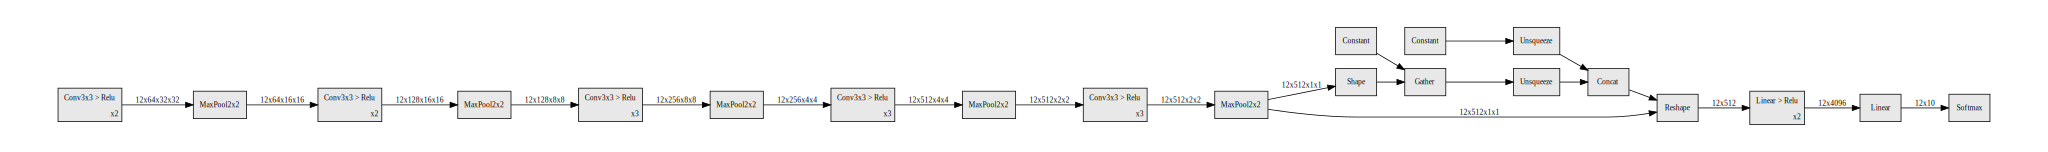

In [6]:
import hiddenlayer as hl
hl.build_graph(model, torch.zeros([12, 3, 32, 32]).to(DEVICE))

## Training

In [7]:
def compute_accuracy(model, data_loader):
    model.eval()
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
            
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)

        logits, probas = model(features)
        _, predicted_labels = torch.max(probas, 1)
        num_examples += targets.size(0)
        correct_pred += (predicted_labels == targets).sum()
    return correct_pred.float()/num_examples * 100


def compute_epoch_loss(model, data_loader):
    model.eval()
    curr_loss, num_examples = 0., 0
    with torch.no_grad():
        for features, targets in data_loader:
            features = features.to(DEVICE)
            targets = targets.to(DEVICE)
            logits, probas = model(features)
            loss = F.cross_entropy(logits, targets, reduction='sum')
            num_examples += targets.size(0)
            curr_loss += loss

        curr_loss = curr_loss / num_examples
        return curr_loss
    
    

start_time = time.time()
for epoch in range(num_epochs):
    
    model.train()
    for batch_idx, (features, targets) in enumerate(train_loader):
        
        features = features.to(DEVICE)
        targets = targets.to(DEVICE)
            
        ### FORWARD AND BACK PROP
        logits, probas = model(features)
        cost = F.cross_entropy(logits, targets)
        optimizer.zero_grad()
        
        cost.backward()
        
        ### UPDATE MODEL PARAMETERS
        optimizer.step()
        
        ### LOGGING
        if not batch_idx % 50:
            print ('Epoch: %03d/%03d | Batch %04d/%04d | Cost: %.4f' 
                   %(epoch+1, num_epochs, batch_idx, 
                     len(train_loader), cost))

    model.eval()
    with torch.set_grad_enabled(False): # save memory during inference
        print('Epoch: %03d/%03d | Train: %.3f%% |  Loss: %.3f' % (
              epoch+1, num_epochs, 
              compute_accuracy(model, train_loader),
              compute_epoch_loss(model, train_loader)))


    print('Time elapsed: %.2f min' % ((time.time() - start_time)/60))
    
print('Total Training Time: %.2f min' % ((time.time() - start_time)/60))

Epoch: 001/010 | Batch 0000/0391 | Cost: 2.4443
Epoch: 001/010 | Batch 0050/0391 | Cost: 2.1140
Epoch: 001/010 | Batch 0100/0391 | Cost: 2.0593
Epoch: 001/010 | Batch 0150/0391 | Cost: 1.9448
Epoch: 001/010 | Batch 0200/0391 | Cost: 2.0826
Epoch: 001/010 | Batch 0250/0391 | Cost: 1.8528
Epoch: 001/010 | Batch 0300/0391 | Cost: 1.7034
Epoch: 001/010 | Batch 0350/0391 | Cost: 1.7008
Epoch: 001/010 | Train: 32.768% |  Loss: 1.771
Time elapsed: 2.25 min
Epoch: 002/010 | Batch 0000/0391 | Cost: 1.7777
Epoch: 002/010 | Batch 0050/0391 | Cost: 1.6663
Epoch: 002/010 | Batch 0100/0391 | Cost: 1.5214
Epoch: 002/010 | Batch 0150/0391 | Cost: 1.5125
Epoch: 002/010 | Batch 0200/0391 | Cost: 1.3399
Epoch: 002/010 | Batch 0250/0391 | Cost: 1.3863
Epoch: 002/010 | Batch 0300/0391 | Cost: 1.4996
Epoch: 002/010 | Batch 0350/0391 | Cost: 1.2441
Epoch: 002/010 | Train: 51.818% |  Loss: 1.309
Time elapsed: 4.53 min
Epoch: 003/010 | Batch 0000/0391 | Cost: 1.2667
Epoch: 003/010 | Batch 0050/0391 | Cost: 1.2

## Evaluation

In [8]:
with torch.set_grad_enabled(False): # save memory during inference
    print('Test accuracy: %.2f%%' % (compute_accuracy(model, test_loader)))

Test accuracy: 76.00%


In [9]:
%watermark -iv

torch 1.5.1+cu101
numpy 1.18.5

